# AST 7939 Homework Assignment #3 (10 pts)

Savannah Gramze

Use photometric data with different filters to infer the redshift.

If we have photometry and spectroscopy for certain galaxies, we can use machine learning to train to infer the redshifts of certain galaxies using photometry.

## All work is due Monday March 6 at 5 pm.

## Instruction: 
Do all homework in this Jupyter notebook and submit your final .ipynb file via Canvas. Show ALL your work and try to add comment lines as needed to describe what your code does. 

You are encouraged to discuss homework problems with your classmates. However, your python script and answers to the questions must be written by yourself.

## Regression with ensemble methods

### 1. Photometric redshift estimator using Random Forest (7 pts)

Following [Zhou et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019MNRAS.488.4565Z/abstract), the goal of this homework is to estimate photometric redshifts starting from observations of galaxy magnitudes in six different photometric bands (u, g, r, i, z, y), and compare the estimated photometric redshifts with spectroscopic redshifts. The data used in the paper are available at this [link](http://d-scholarship.pitt.edu/36064/). This example is motivated by an example in Machine Learning techniques for Physics and Astronomy that is being written by Dr. Viviana Acquaviva.

Redshift is a crucial observable in the study of galaxies and cosmology. Spectroscopic redshifts are accurate, but the observations required are much more expensive than photometric measurements. Modern imaging surveys can measure the photometry of a huge number of objects very efficiently, but only a very small fraction will have observed spectra. For such surveys, redshifts must be estimated from broad-band photometry, and the large number of photometric redshift measurements compensates for their inaccuracy. The availability of large imaging data sets has made photometric redshift estimates an increasingly important component of modern extragalactic astronomy and cosmology studies.



The paper used ugriz photometry from Canada–France–Hawaii Telescope Legacy Survey (CFHTLS) and Y-band photometry from the Subaru Suprime camera, as well as spectroscopic redshifts from the DEEP2, DEEP3, and 3D-HST surveys. In this homework problem, let's use DEEP2/3 data stored in DEEP2_uniq_Terapix_Subaru_v1.fits. You can read in the fits file by executing the cell below. See README file for more information on the content of the fits file.

In [101]:
import astropy
from astropy.io import fits
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

with fits.open('./DEEP2_uniq_Terapix_Subaru_v1.fits') as data:
    df = pd.DataFrame(np.array(data[1].data).byteswap().newbyteorder()) 

(a) As in almost all real-life ML problems, start with data cleaning. Follow the steps below. (1 pt)

1. Collect deep field CFHTLS data only by choosing the objects with `cfhtls_source` = 0.
2. Collect deep source subaru data only by choosing the objects with `subaru_source` = 0.
3. Collect objects with redshift quality code `zquality` >= 3.
4. Collect objects with `u_apercor` < 99.
5. Collect objects with `y_apercor` < 99.

The 'features' we will use are aperture corrected ugrizy magnitudes, `u_apercor, g_apercor, r_apercor, i_apercor, z_apercor, y_apercor`. The 'label' we will use is the spectroscopic redshift `zhelio`. Put the features in a dataframe X and labels in a dataframe y. You should end up with 5874 objects after data cleaning. Split the data into training and test datasets.

In [102]:
from sklearn.model_selection import train_test_split

In [103]:
cfdtls_data = df[df['cfhtls_source'] == 0]#.keys()
deep_source = cfdtls_data[cfdtls_data['subaru_source'] == 0]
quality_red = deep_source[deep_source['zquality'] >= 3.]
clean_u = quality_red[quality_red['u_apercor'] < 99]
clean_df = clean_u[clean_u['y_apercor'] < 99]

X = clean_df[['u_apercor', 'g_apercor', 'r_apercor', 'i_apercor', 'z_apercor', 'y_apercor']]
y = clean_df['zhelio']

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y))

(b) Make a `RandomForestRegressor` model. Use the default hyperparameters for now (we will optimize them later). Compute the accuracy of the model in two ways. (1 pt)

1. Compute the training and test scores of the model using 5-fold cross validation. You will get 5 scores. Report the average of the 5 scores.
2. Compute the out-of-bag test score. 

In [104]:
# every time you bootstrap, there are some data left in original dataset
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
#KFold?
#RandomForestRegressor?
#model.fit?

In [105]:
model = RandomForestRegressor(oob_score=True) # Initialize RandomForestRegressor
model.fit(X_train, y_train) # Fit the model on training data

RandomForestRegressor(oob_score=True)

In [106]:
scores = cross_val_score(model, X_train, y_train, cv=5) # Get Cross Validation Scores

In [107]:
scores # Print out all 5 scores computed

array([0.83403136, 0.68200841, 0.66629142, 0.70518724, 0.72565735])

In [108]:
np.mean(scores) # Mean of all 5 cross validation scores

0.722635157073348

In [109]:
model.oob_score_  # Out-of-the-box score

0.7188981301847104

(c) Using the `RandomForestRegressor` you built in #b, make predictions for the test dataset. This prediction will be the "photometric redshift". Then, make a scatter plot showing photometric redshift vs. spectroscopic redshift. Your figure should look similar to Figure 5 of Zhou et al. (2019). Also, compute the outlier fraction $\eta$, which is defined as the fraction of objects with $|z_{phot}-z_{spec}| > 0.15/(1+z_{spec})$. (1 pt)

Text(0, 0.5, 'z$_{phot}$')

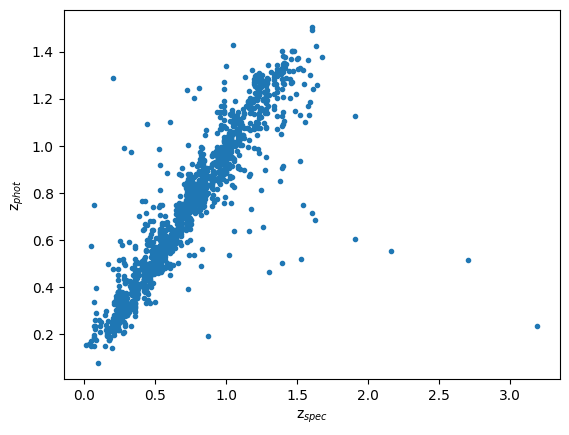

In [110]:
# make predictions for test dataset
# make a plot showing inferred photometric redshift vs actual spectroscopic redshift
# 6% of the data are outliers in the paper
# How much of the data are outliers?

# Same as model above btw
model = RandomForestRegressor(oob_score=True) # Initialize RandomForestRegressor
model.fit(X_train, y_train) # Fit the model on training data

z_phot = model.predict(X_test) # using the model from above, predict the redshift for the test data
z_spec = np.array(y_test) # the true redshifts from spectroscopy

# Plot and compare
plt.scatter(z_spec, z_phot, marker='.')
plt.xlabel('z$_{spec}$')
plt.ylabel('z$_{phot}$')


In [111]:
count = 0

for i in range(len(z_phot)):
    if np.abs(z_phot[i] - z_spec[i]) > 0.15 / (1 + z_spec[i]): # count how many objects $|z_{phot}-z_{spec}| > 0.15/(1+z_{spec})$ is true for
        count += 1

eta = count / len(z_phot) # find the fraction of objects its true for
eta

0.2600408441116406

(d) Let's try to optimize hyperparameters `max_features` and `n_estimators`. For `max_features`, try three different values: None, "sqrt", and 2. Compute the test scores of the best model and compare them with what you got in #b. (1 pt)

In [113]:
from sklearn.model_selection import GridSearchCV

In [126]:
# optimize max_features in random forest
# try None, sqrt and 2 for max_features (# of dimensions?)

# hyperparameter optimization

param_grid = {'max_features': [None, 'sqrt', 2], # Grid set up for hyperparameter optimization
              'n_estimators': [100, 200, 300, 400] # max_features as specified
              }

grid_search = GridSearchCV(RandomForestRegressor(oob_score=True),  # specify RFR
                           param_grid, cv=5, return_train_score=True, verbose=1) 
grid_search.fit(X_train, y_train) # Fit for best model with training data

print("Best parameters: {}".format(grid_search.best_params_)) # print out best parameters
print("Best model: {}".format(grid_search.best_estimator_)) # print out the best model
print("Test score: {:.2f}".format(grid_search.score(X_test, y_test))) # print out the test score of the best model

# Test score of 0.75 is not that much better than default



Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'max_features': None, 'n_estimators': 300}
Best model: RandomForestRegressor(max_features=None, n_estimators=300, oob_score=True)
Test score: 0.77


In [127]:
model = RandomForestRegressor(max_features=None, n_estimators=100, oob_score=True)
model.fit(X_train, y_train)

RandomForestRegressor(max_features=None, oob_score=True)

In [128]:
model.score(X_test, y_test)

0.7668895368763242

In [129]:
scores = cross_val_score(model, X_train, y_train, cv=5) # Get Cross Validation Scores
scores

array([0.83351516, 0.68210343, 0.67392006, 0.70965951, 0.72817353])

In [130]:
np.mean(scores) # Mean of all 5 cross validation scores

0.7254743380725304

In [131]:
model.oob_score_  # Out-of-the-box score

0.7158116673247579

(e) You might have found that the test scores are not drastically improved. What should we do? Let's try to add u-g, g-r, r-i, i-z, z-y colors and see if it improves the performance. You now have a 11-dimensional dataset. Using this new dataset, make a Random Forest, optimize hyperparameters, and compute the test score of the best model. (1 pt)

In [141]:
# 70-80%, not super good
# to try to improve, add more features, ie colors
# make 5 colors and add them for 11 dimensions 

# Calculate the values of the colors
color_ug = clean_df['u_apercor'] - clean_df['g_apercor']
color_gr = clean_df['g_apercor'] - clean_df['r_apercor']
color_ri = clean_df['r_apercor'] - clean_df['i_apercor']
color_iz = clean_df['i_apercor'] - clean_df['z_apercor']
color_zy = clean_df['z_apercor'] - clean_df['y_apercor']

X = np.array([clean_df['u_apercor'], clean_df['g_apercor'], clean_df['r_apercor'], # initialize X array with colors added
          clean_df['i_apercor'], clean_df['z_apercor'], clean_df['y_apercor'],
         color_ug, color_gr, color_ri, color_iz, color_zy]
        ).T
feature_names = ['u', 'g', 'r', 'i', 'z', 'y', 'u-g', 'g-r', 'r-i', 'i-z', 'z-y']
y = clean_df['zhelio']

X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y))



In [142]:
model = RandomForestRegressor(oob_score=True) # Initialize RandomForestRegressor
model.fit(X_train, y_train) # Fit the model on training data

RandomForestRegressor(oob_score=True)

In [143]:
scores = cross_val_score(model, X_train, y_train, cv=5) # Get Cross Validation Scores
scores

array([0.7552823 , 0.81976356, 0.84439023, 0.82462462, 0.7479283 ])

In [144]:
np.mean(scores) # Mean of all 5 cross validation scores

0.7983978022306923

In [145]:
model.oob_score_  # Out-of-the-box score

0.7888450077931717

In [146]:
# hyperparameter optimization

param_grid = {'max_features': [None, 'sqrt', 2], # Grid set up for hyperparameter optimization
              'n_estimators': [100, 200, 250, 300] # max_features as specified
              }

grid_search = GridSearchCV(RandomForestRegressor(),  # specify RFR
                           param_grid, cv=5, return_train_score=True, verbose=1) 
grid_search.fit(X_train, y_train) # Fit for best model with training data

print("Best parameters: {}".format(grid_search.best_params_)) # print out best parameters
print("Best model: {}".format(grid_search.best_estimator_)) # print out the best model
print("Test score: {:.2f}".format(grid_search.score(X_test, y_test))) # print out the test score of the best model

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'max_features': 'sqrt', 'n_estimators': 250}
Best model: RandomForestRegressor(max_features='sqrt', n_estimators=250)
Test score: 0.78


(f) With your best model, repeat #c. Make a plot showing photometric redshift vs. spectroscopic redshift, and compute the outlier fraction. Do you find better perfomance? (1 pt)

Text(0, 0.5, 'z$_{phot}$')

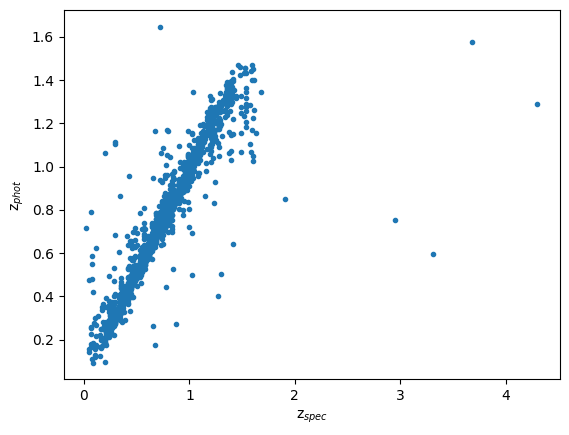

In [147]:
# Same as model above btw
model = RandomForestRegressor(max_features='sqrt', n_estimators=250, oob_score=True) # Initialize RandomForestRegressor
model.fit(X_train, y_train) # Fit the model on training data

z_phot = model.predict(X_test) # using the model from above, predict the redshift for the test data
z_spec = np.array(y_test) # the true redshifts from spectroscopy

# Plot and compare
plt.scatter(z_spec, z_phot, marker='.')
plt.xlabel('z$_{spec}$')
plt.ylabel('z$_{phot}$')


In [148]:
count = 0

for i in range(len(z_phot)):
    if np.abs(z_phot[i] - z_spec[i]) > 0.15 / (1 + z_spec[i]): # count how many objects $|z_{phot}-z_{spec}| > 0.15/(1+z_{spec})$ is true for
        count += 1

eta = count / len(z_phot) # find the fraction of objects its true for
eta

0.17018379850238258

(g) Make a plot showing feature importance. Which is more important between colors and magnitudes? Does the feature importance plot support that adding colors helped improve the performance? (1 pt)

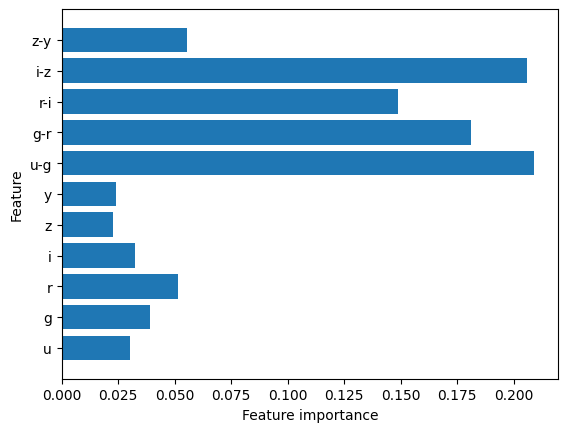

In [150]:
# show feature importance bar graph 
# which are the most important features?

# Like the bar chart from class
# Use best random forest regressor
model_best_rf = RandomForestRegressor(max_features='sqrt', n_estimators=250, oob_score=True)
model_best_rf.fit(X_train, y_train)

# Using same code to plot bar chart from class
def plot_feature_importances(model):
    n_features = X.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(model_best_rf)
# Looks like the best model puts much more importance on the colors than the magnitudes, 
# so that supports the idea that adding colors improved the model.

### 2. Photometric redshift estimator using Gradient Boosting (3 pts)


This time, let's use Gradient Boosting to compute photometric redshift. 

(a) Let's use `max_depth=2`. What `n_estimator` should we use? Make a plot showing the validation error vs. n_estimator and find the optimal `n_estimator`. What is your optimal `n_estimator` and what is the test score using the optimal model? (1 pt)

In [151]:
# boosting, gradient
# use decision tree with max_depth=2
# can use as many n_estimator as you want, but what is optimal?
# find the best gradient boosting model

from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor(max_depth=2, n_estimators=20, 
                                  learning_rate=1.0, random_state=42)
model.fit(X, y)


GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=20,
                          random_state=42)

(b) Using the `GradientBoostingRegressor` you built in #a, make predictions for the test dataset. This prediction will be the "photometric redshift". Then, make a scatter plot showing photometric redshift vs. spectroscopic redshift. Your figure should look similar to Figure 5 of Zhou et al. (2019). Also, compute the outlier fraction $\eta$, which is defined as the fraction of objects with $|z_{phot}-z_{spec}| > 0.15/(1+z_{spec})$. (1 pt)

In [ ]:
# compare with random forest












(c) Make a movie showing the evolution of photometric redshift vs. spectroscopic redshift as you increase `n_estimator`. See gbr.mp4 on Canvas as an example. Discuss what you see in the movie in the context of boosting. Submit your movie file. (1 pt)

In [ ]:
# make a movie??????
# make a png for each n_estimator and then combine into 1000 frame mp4











### Congratulations! You reproduced results presented in yet another journal paper. If you enjoyed the homework and would like to do some additional related analysis, I recommend you have a look at the following papers and references therein. Feel free to read/reproduce them for paper presentation and/or term project.

https://ui.adsabs.harvard.edu/abs/2010ApJ...712..511C/abstract

https://ui.adsabs.harvard.edu/abs/2021MNRAS.505.4847H/abstract

https://ui.adsabs.harvard.edu/abs/2022MNRAS.509.2289L/abstract

https://ui.adsabs.harvard.edu/abs/2022MNRAS.512.1696H/abstract